<table>
    <tr>
        <td><img src="./img/Macc.png" width="auto"/></td>
        <td>
            <table><tr>
            <h1 style="color:blue;text-align:center">Lógica para Ciencias de la Computación</h1></td>
            </tr></table>   
        <td>&nbsp;</td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Taller</p></tp>
            <tp><p style="font-size:150%;text-align:center">Algoritmo DPLL</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

# Objetivo <a class="anchor" id="inicio"></a>

Hasta este punto del curso hemos visto cómo resolver problemas, representando una situación mediante una fórmula de la lógica proposicional y buscando un modelo para ella. También vimos que los SATsolver que hemos desarrollado hasta este momento no son eficientes, toda vez que no pueden dar respuesta al problema de la rejilla con un tamaño $3\times 3$. En efecto, tanto SATtabla como SATtableaux agotan los recursos del computador y no logran encontrar un modelo.

En clase acabamos de ver el algoritmo DPLL para encontrar un modelo $I$ para una fórmula $S$ en forma clausal. En este notebook implementaremos el algoritmo DPLL en Python.

Desarrollaremos la explicación mediante las siguientes secciones.

# Secciones

1. [Funciones auxiliares](#aux)
2. [Unit propagation](#unit)
3. [DPLL](#dpll)
4. [Solución de problemas](#sat)


# Funciones auxiliares <a class="anchor" id="aux"></a>

([Volver al inicio](#inicio))

Para poder implementar el algoritmo DPLL de manera eficiente requerimos algunas funciones auxiliares:

* `complemento()`: Sea $\ell$ un literal. Se define 

`complemento`$(\ell)=\begin{cases}
\overline{p},& { si }\space \ell=p\\ 
p,&{ si } \space \ell=\overline{p}\\
\end{cases}$

* `eliminar_literal()`: Toma un conjunto de cláusulas $S$ y un literal $\ell$ y devuelve el conjunto `S'` tal que:

    - Se ha eliminado $C\,{\in}\, S$ si $\ell\,{\in}\, C$,
    - Se ha eliminado $\ell^c$ de las demás cláusulas.

* `extender_I()`: Toma un diccionario $I$ y un literal $\ell$ y modifica el diccionario de manera tal que $\ell$.valor($I$)=`True`.

Implementaremos estas funciones una por una.

**Ejercicio 1:**

Implemente la función `complemento()`.

In [1]:
def complemento(literal: str) -> str:
	if '-' in literal:
		return literal[1:]
	else:
		return '-' + literal

---

Presentamos las otras dos funciones auxiliares. Trate de comprender el código y el uso de la definición de listas por comprensión y listas anidadas. Estas líneas no sólamente son económicas en términos de espacio, sino que son muchísimo más eficientes que el uso de estructuras de control `while` y `for`.

In [2]:
def eliminar_literal(S, l):
    S1 = [c for c in S if l not in c]
    lc = complemento(l)
    return [[p for p in c if p != lc] for c in S1]

def extender_I(I, l):
    I1 = {k:I[k] for k in I if k != l}
    if '-' in l:
        I1[l[1:]] = False
    else:
        I1[l] = True
    return I1

Podemos comprobar el funcionamiento de estas funciones con el ejemplo que usamos en las diapositivas.

In [3]:
S = [['p','-q'], ['-r'], ['-r','p'], ['-p','r']]
l = '-r'
eliminar_literal(S,l)

[['p', '-q'], ['-p']]

In [4]:
I = {}
l = '-r'
extender_I(I, l)

{'r': False}

---

# Unit propagation <a class="anchor" id="unit"></a>

([Volver al inicio](#inicio))

Mediante las funciones auxiliares podemos implementar la función `unit_propagate`.

In [5]:
def unit_propagate(S, I):
    '''
    Algoritmo para eliminar clausulas unitarias de un conjunto de clausulas, manteniendo su satisfacibilidad
    Input: 
        - S, conjunto de clausulas
        - I, interpretacion (diccionario {literal: True/False})
    Output: 
        - S, conjunto de clausulas
        - I, interpretacion (diccionario {literal: True/False})
    '''
    while [] not in S:
        l = ''
        for x in S:
            if len(x) == 1:
                l = x[0]
                S = eliminar_literal(S, l)
                I = extender_I(I, l)
                break
        if l == '': # Se recorrió todo S y no se encontró unidad
            break
    return S, I

Comprobamos el funcionamiento mediante el ejemplo de las diapositivas:

In [6]:
S = [['p'], ['-p', 'q'], ['-q', 'r','s'], ['u', '-s','r'], ['r', 't'], ['p', 's', '-t'], ['-r', 'u']]
I = {}

In [7]:
unit_propagate(S,I)

([['r', 's'], ['u', '-s', 'r'], ['r', 't'], ['-r', 'u']],
 {'p': True, 'q': True})

---

# DPLL <a class="anchor" id="dpll"></a>

([Volver al inicio](#inicio))

Presentamos ahora el algoritmo DPLL.

<img src="./img/dpll.png" width="auto"/>

**Ejercicio 2:**

Implemente el algoritmo DPLL.

In [ ]:
from random import choice

def dpll(S, I):
    '''
    Algoritmo para verificar la satisfacibilidad de una formula, y encontrar un modelo de la misma
    Input: 
        - S, conjunto de clausulas
        - I, interpretacion (diccionario literal->True/False)
    Output: 
        - String, Satisfacible/Insatisfacible
        - I ,interpretacion (diccionario literal->True/False)
    '''
    # Paso 1: Unit Propagation
    S, I = unit_propagate(S, I)

    # Paso 2: Clausula vacía
    if [] in S:
        return "Insatisfacible", I
    
    # Paso 3: Conjunto vacío
    if not S:
        return "Satisfacible", I

    # Paso 4: Un literal (l) perteneciente a S que no se encuentre asignado en I
    unassigned_literals = [literal for clause in S for literal in clause if literal not in I and '-' + literal not in I]
    if unassigned_literals:
        l = choice(unassigned_literals)

    # Paso 5: S' (S_) como el conjunto de clausulas que contienen a l y eleminando a c(l) de las clausulas restantes
    S_ = eliminar_literal(S, l)

    # Paso 6: I' (I_) como la interpretación donde V_I'(l) = True
    I_ = extender_I(I, l)

    # Paso 7: Paso recursivo DPLL para S' e I'
    result = dpll(S_, I_)
    if result[0] == "Satisfacible":
        return result
    
    # Paso 8: Si no
    else:
        # Paso 9: S'' (S__) como el conjunto de clausulas que contienen a l y eleminando a c(l) de las clausulas restantes
        S__ = eliminar_literal(S, complemento(l))

        # Paso 10: I'' (I__) como la interpretación donde V_I''(l) = True
        I__ = extender_I(I, complemento(l))

        # Paso 11: Retornar DPLL para S'' e I''
        return dpll(S__, I__)

Pruebe su respuesta con los siguientes ejemplos:

1. `S = [['r'], ['p', '-r'], ['q', '-r'], ['-p', '-q', 'r']]` 

Solución:  $I\,{=}\,\{r: True, p: True, q: True\}$.

2. `S=[['s'], ['-r', '-q'], ['r', 'q'], ['p', '-s'], ['r', '-s'], ['-p', '-r', 's']]` 

Solución: $I\,{=}\,\{s: True, p: True, r: True, q: False\}$.

3. `S = [['s'], ['p','-t'], ['q','-t'], ['-p','-q','t'], ['t','-s'], ['r','-s'], ['-t','-r','s']]` 

Solución: $I\,{=}\,\{s: True, p: True, r: True, q: False\}$.

4. `S = [['p','-q'],['-p','-q'],['q','r'],['-q''-r'],['-p','-r'],['p','-r']]` 

Solución: insatisfacible.


In [9]:
S = [['r'], ['p', '-r'], ['q', '-r'], ['-p', '-q', 'r']]
dpll(S, {})

('Satisfacible', {'r': True, 'p': True, 'q': True})

In [10]:
S = [['s'], ['-r', '-q'], ['r', 'q'], ['p', '-s'], ['r', '-s'], ['-p', '-r', 's']]
dpll(S, {})

('Satisfacible', {'s': True, 'p': True, 'r': True, 'q': False})

In [11]:
S = [['s'], ['p','-t'], ['q','-t'], ['-p','-q','t'], ['t','-s'], ['r','-s'], ['-t','-r','s']]
dpll(S, {})

('Satisfacible', {'s': True, 't': True, 'p': True, 'q': True, 'r': True})

In [12]:
S = [['p','-q'],['-p','-q'],['q','r'],['-q''-r'],['-p','-r'],['p','-r']]
dpll(S, {})

('Insatisfacible', {'q-r': False, 'q': True, 'p': True})

---

# Solución de problemas <a class="anchor" id="sat"></a>

([Volver al inicio](#inicio))

Retomaremos aquí el problema con el que estudiamos la representación de situaciones. Buscamos llenar todas las casillas en una tabla 2x2 con un número de 0 a 3, sin repetir. Por ejemplo:

![ejemplo](img/tabla.png)

Tenemos tres restricciones que debemos implementar para resolver el problema:

1. Un número sólo está en una casilla.

2. No hay más de un número en una casilla.

3. Debe haber por lo menos un número en una casilla.

Las reglas ya están implementadas en la clase `Rejilla`.

In [13]:
from Problemas import Rejilla
from Logica import *

Buscamos una solución mediante el DPLL:

CPU times: total: 3.09 s
Wall time: 3.09 s


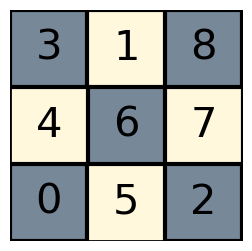

In [14]:
%%time
r = Rejilla(N=3, M=3)
A = Ytoria(r.reglas)
S = tseitin(A)
S, I = dpll(S, {})
if I != None:
    r.visualizar(I)
else:
    print('¡No hay solución!')

Vemos que se obtiene una respuesta y que el algoritmo es bastante rápido.

---